## This notebook calculates the following metrics sourced from Cal-Adapt Tools: Wildfire
* Change in total area burned per tract per year

In [1]:
import pandas as pd
import os
import sys
import math
import geopandas as gpd
import xarray as xr
import cftime

import pyproj
import rioxarray as rio
import xarray as xr
import numpy as np

# projection information
import cartopy.crs as ccrs

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import upload_csv_aws, filter_counties
from scripts.utils.write_metadata import append_metadata

In [2]:
def process_fire_data(fn):
    bucket_loc = "s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/"
    filepath = bucket_loc + fn + "_AA.monthly_all.bau.mu.nc.zarr"
    print('Opening: {}'.format(filepath))
    ds = xr.open_dataset(
        filepath, 
        engine="zarr",
        consolidated=False,
        decode_times=False
    )    
    units, refdate = ds.time.attrs['units'].split('since')
    ds['time'] = pd.date_range(start=refdate, periods=ds.sizes['time'], freq='MS')

    # make mask to re-nan out grid cells with no data,
    # since summing per year ends up turning the nans to 0
    mask_layer = ds.isel(time=0).squeeze()

    # calculate annual area burned
    print('Calculating annual sum of area burned...')
    ds = ds.resample(time='1Y').sum()

    # mask out grid cells which originally had nans
    ds = xr.where(np.isnan(mask_layer), x=np.nan, y=ds)

    return ds

def convert_30yr(start):
    return (start-5, start+24)

In [3]:
# this takes a few minutes because it is opening the file and then pre-processing by calculating the annual sum
# approx 2 min  per file
# RCP 4.5
miroc45 = process_fire_data(fn='MIROC5_45')
cnrm45 = process_fire_data(fn='CNRM-CM5_45')
hadgem45 = process_fire_data(fn='HadGEM2-ES_45')
canesm45 = process_fire_data(fn='CanESM2_45')

# RCP 8.5
miroc85 = process_fire_data(fn='MIROC5_85')
cnrm85 = process_fire_data(fn='CNRM-CM5_85')
hadgem85 = process_fire_data(fn='HadGEM2-ES_85')
canesm85 = process_fire_data(fn='CanESM2_85')

Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/MIROC5_45_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...


/home/bethmints/miniconda3/envs/carb/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/CNRM-CM5_45_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...


/home/bethmints/miniconda3/envs/carb/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/HadGEM2-ES_45_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...


/home/bethmints/miniconda3/envs/carb/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/CanESM2_45_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...


/home/bethmints/miniconda3/envs/carb/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/MIROC5_85_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...


/home/bethmints/miniconda3/envs/carb/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/CNRM-CM5_85_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...


/home/bethmints/miniconda3/envs/carb/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/HadGEM2-ES_85_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...


/home/bethmints/miniconda3/envs/carb/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/CanESM2_85_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...


/home/bethmints/miniconda3/envs/carb/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


#### Step 1a) Calculate historical baseline (1981-2010)

In [4]:
# grab historical period in each, and take multimodel mean
all_sims = [miroc45, miroc85, cnrm45, cnrm85, hadgem45, hadgem85, canesm45, canesm85]

ds_hist = xr.concat(all_sims, 'simulation')
ds_hist = ds_hist.sel(time=slice('1981', '2010')).mean(dim='time').mean(dim='simulation') # subset for historical baseline period, and take multi-model mean
ds_hist

Let's do a quick validation of the data before moving on.

In [10]:
# sum total area to compare against historical observations
# convert to acres for easy comparison 
acre_per_hectare = 2.47105
ds_hist_sum = ds_hist.sum()*acre_per_hectare
print(f"Historical model-mean total burned area in CA is {ds_hist_sum.hectares.values} acres.")

Historical model-mean total burned area in CA is 451861.3767609375 acres.


[Wikipedia article on CA wildfires says](https://en.wikipedia.org/wiki/List_of_California_wildfires): "...since 2000, the area that burned annually has ranged between 90,000 acres... and 1,590,000 acres...", so an average annual burn of ~452,000 acres is reasonable especially when considering the earlier time period considered in the historical data. 

#### Step 1b) Calculate warming level per model
This will have to be manually done per model
* https://github.com/mathause/cmip_warming_levels/blob/main/warming_levels/cmip5_all_ens/csv/cmip5_warming_levels_all_ens_1850_1900_no_bounds_check.csv
* Assuming all models are r1i1ip1f1
* The csv file at loc above has typos in it, making it unreadable programmatically -- working manually
   * uses a 20 year average around start year
   * MIROC5 4.5 -- 2063-2082, MIROC5 8.5 -- 2039-2058
   * CNRM-CM5 4.5 -- 2049-2068, CNRM-CM5 8.5 -- 2036-2055
   * HADGEM-ES 4.5 -- 2034-2053, HADGEM-ES 8.5 -- 2026-2045
   * CANESM2 4.5 -- 2022-2041, CANESM2 8.5 -- 2017-2036

In [11]:
sim_yrs = {
    'miroc45'  : 2063,
    'miroc85'  : 2039,
    'cnrm45'   : 2049,
    'cnrm85'   : 2036,
    'hadgem45' : 2034,
    'hadgem85' : 2026,
    'canesm45' : 2022,
    'canesm85' : 2017
}

for i in sim_yrs.keys():
    print(i, '20-yr-start: ', sim_yrs.get(i), '30-yr range:', convert_30yr(sim_yrs.get(i)))

miroc45 20-yr-start:  2063 30-yr range: (2058, 2087)
miroc85 20-yr-start:  2039 30-yr range: (2034, 2063)
cnrm45 20-yr-start:  2049 30-yr range: (2044, 2073)
cnrm85 20-yr-start:  2036 30-yr range: (2031, 2060)
hadgem45 20-yr-start:  2034 30-yr range: (2029, 2058)
hadgem85 20-yr-start:  2026 30-yr range: (2021, 2050)
canesm45 20-yr-start:  2022 30-yr range: (2017, 2046)
canesm85 20-yr-start:  2017 30-yr range: (2012, 2041)


In [12]:
# RCP 4.5
miroc45_wl = miroc45.sel(time=slice('2058', '2087')).mean(dim='time')
cnrm45_wl = cnrm45.sel(time=slice('2044', '2073')).mean(dim='time')
hadgem45_wl = hadgem45.sel(time=slice('2029', '2058')).mean(dim='time')
canesm45_wl = canesm45.sel(time=slice('2017', '2046')).mean(dim='time')

# RCP 8.5
miroc85_wl = miroc85.sel(time=slice('2034', '2063')).mean(dim='time')
cnrm85_wl = cnrm85.sel(time=slice('2031', '2060')).mean(dim='time')
hadgem85_wl = hadgem85.sel(time=slice('2021', '2050')).mean(dim='time')
canesm85_wl = canesm85.sel(time=slice('2012', '2041')).mean(dim='time')

projs = [miroc45_wl, miroc85_wl, cnrm45_wl, cnrm85_wl, hadgem45_wl, hadgem85_wl, canesm45_wl, canesm85_wl]
ds_proj = xr.concat(projs,'simulation')
ds_proj = ds_proj.mean(dim='simulation')
ds_proj

<xarray.Dataset>
Dimensions:   (lat: 179, lon: 173)
Coordinates:
  * lat       (lat) float64 31.59 31.66 31.72 31.78 ... 42.53 42.59 42.66 42.72
  * lon       (lon) float64 -124.5 -124.5 -124.4 -124.3 ... -113.9 -113.8 -113.8
Data variables:
    hectares  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

#### Step 2: Calculate delta signal

In [13]:
ds_delta = ds_proj - ds_hist

#### Step 3: Reproject data to census tract projection

In [14]:
# read in CA census tiger file -- not working from s3 link, uploading manually to keep testing
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)

column_names = ca_boundaries.columns
ca_boundaries = ca_boundaries.to_crs(crs=3857) 
ca_boundaries = ca_boundaries.set_index(['GEOID'])

In [15]:
df = ds_delta.to_dataframe().reset_index()
df

,lat,lon,hectares
0,31.59375,-124.53125,NaN
1,31.59375,-124.46875,NaN
2,31.59375,-124.40625,NaN
3,31.59375,-124.34375,NaN
4,31.59375,-124.28125,NaN
...,...,...,...
30962,42.71875,-114.03125,NaN
30963,42.71875,-113.96875,NaN
30964,42.71875,-113.90625,NaN
30965,42.71875,-113.84375,NaN


In [16]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon,df.lat), crs="EPSG:4326")
gdf = gdf.to_crs(ca_boundaries.crs)

In [17]:
# spatially join gridded data with the census tracts
clipped_gdf = gpd.sjoin(ca_boundaries, gdf, how='left', predicate='intersects')
clipped_gdf = clipped_gdf[["geometry","hectares"]]
clipped_gdf

,geometry,hectares
GEOID,,
06085504321,"POLYGON ((-13567125.366 4494902.743, -13567102...",NaN
06085504410,"POLYGON ((-13568606.361 4496070.766, -13568261...",NaN
06085507003,"POLYGON ((-13583749.029 4469373.052, -13583714...",NaN
06085507004,"POLYGON ((-13580203.383 4470602.095, -13580142...",NaN
06085502204,"POLYGON ((-13573372.106 4480730.095, -13572964...",NaN
...,...,...
06059001303,"POLYGON ((-13131155.246 4018679.418, -13131122...",NaN
06059001304,"POLYGON ((-13131155.692 4019165.343, -13131058...",NaN
06059001401,"POLYGON ((-13130196.230 4021423.785, -13130195...",NaN


In [20]:
# We need to ensure that a tract which contains any nan grid points - ie no data 
# from the original gridded burn product - is completely nan'd out,
# even if any valid grid points are contained in it. This is because a 
# nan counts as 0 when summing and can result in artifically inflated
# or deflated values for which we can have little confidence. It is an unavoidable
# underlying limitation of this spatially-incomplete dataset. 

# separate the invalid data from the valid data
valid_gdf = clipped_gdf[~np.isnan(clipped_gdf["hectares"])]
valid_gdf

,geometry,hectares
GEOID,,
06085505010,"POLYGON ((-13579543.306 4495421.665, -13579537...",-1.869791
06085503338,"POLYGON ((-13559845.214 4480259.640, -13559818...",-6.360751
06059032063,"POLYGON ((-13091690.824 3957056.575, -13091622...",-23.047712
06059052430,"POLYGON ((-13106745.472 3990893.705, -13106550...",13.928791
06059052430,"POLYGON ((-13106745.472 3990893.705, -13106550...",4.690002
...,...,...
06013356001,"POLYGON ((-13610178.655 4582637.497, -13610160...",0.542791
06013990000,"POLYGON ((-13630134.800 4575526.449, -13630134...",0.898956
06065040609,"POLYGON ((-13099648.200 4013871.747, -13099664...",-7.568752


In [21]:
# now sum all valid grid cells contained within the tracts
diss_gdf_valid = valid_gdf.reset_index().dissolve(by='GEOID', aggfunc='sum')
display(diss_gdf_valid)

,geometry,hectares
GEOID,,
06001404400,"POLYGON ((-13606912.149 4558475.321, -13606901...",-4.661416
06001407101,"POLYGON ((-13605368.062 4548703.687, -13605361...",-1.550625
06001408100,"POLYGON ((-13601571.732 4550985.962, -13601548...",-3.743917
06001428700,"POLYGON ((-13618883.925 4551445.533, -13618005...",-0.656334
06001430101,"POLYGON ((-13587654.058 4536230.446, -13587648...",5.258753
...,...,...
06115040902,"POLYGON ((-13522767.502 4742271.822, -13522447...",-3.817290
06115041001,"POLYGON ((-13540489.843 4757115.786, -13540482...",-5.114918
06115041002,"POLYGON ((-13521828.008 4769594.064, -13521673...",1.072711


In [22]:
# now make a new geodataframe with all GEOIDs and set hectares to nan
gdf_to_fill = ca_boundaries[["geometry"]]
gdf_to_fill["hectares"] = np.nan
# last, fill nans with valid data where it exists
filled_gdf = (diss_gdf_valid.combine_first(gdf_to_fill))
filled_gdf

/home/bethmints/miniconda3/envs/carb/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry,hectares
GEOID,,
06001400100,"POLYGON ((-13608463.819 4563243.147, -13608434...",NaN
06001400200,"POLYGON ((-13609689.796 4557215.312, -13609668...",NaN
06001400300,"POLYGON ((-13610547.849 4556514.742, -13610540...",NaN
06001400400,"POLYGON ((-13610124.277 4557076.745, -13610121...",NaN
06001400500,"POLYGON ((-13610979.320 4558057.750, -13610964...",NaN
...,...,...
06115040902,"POLYGON ((-13522767.502 4742271.822, -13522447...",-3.817290
06115041001,"POLYGON ((-13540489.843 4757115.786, -13540482...",-5.114918
06115041002,"POLYGON ((-13521828.008 4769594.064, -13521673...",1.072711


<Axes: >

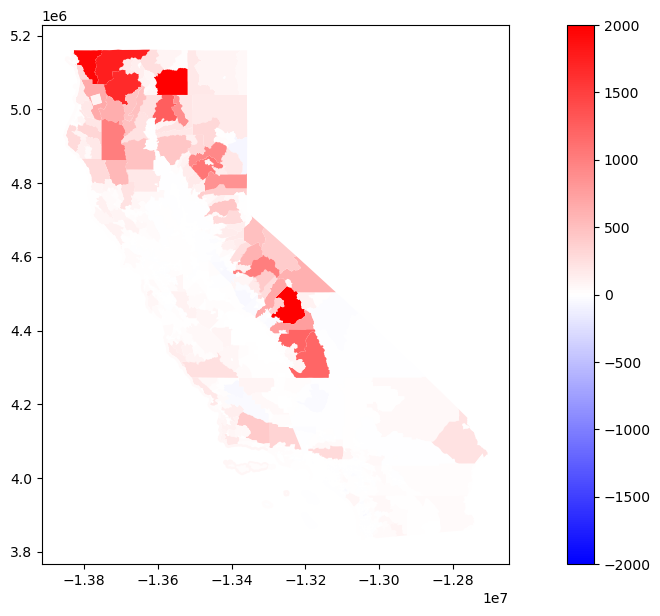

In [75]:
import matplotlib.pyplot as plt

cmap = 'bwr'
fig, ax = plt.subplots(figsize=(15, 7))
filled_gdf.plot(column='hectares', cmap=cmap, legend=True, ax=ax, vmin=-2000, vmax=2000)

#### Step 4: Min-max standardization
Using Cal-CRAI min-max standardization function, available in `utils.calculate_index.py`

In [76]:
def min_max_standardize(df, cols_to_run_on):
    '''
    Calculates min and max values for specified columns, then calculates
    min-max standardized values.

    Parameters
    ----------
    df: DataFrame
        Input dataframe   
    cols_to_run_on: list
        List of columns to calculate min, max, and standardize
    '''
    for col in cols_to_run_on:
        max_value = df[col].max()
        min_value = df[col].min()

        # Get min-max values, standardize, and add columns to df
        prefix = col # Extracting the prefix from the column name
        df[f'{prefix}_min'] = min_value
        df[f'{prefix}_max'] = max_value
        df[f'{prefix}_min_max_standardized'] = ((df[col] - min_value) / (max_value - min_value))
        
        # note to add checker to make sure new min_max column values arent < 0 >
        
        # Drop the original columns
        # df.drop(columns=[col], inplace=True)
     
    return df

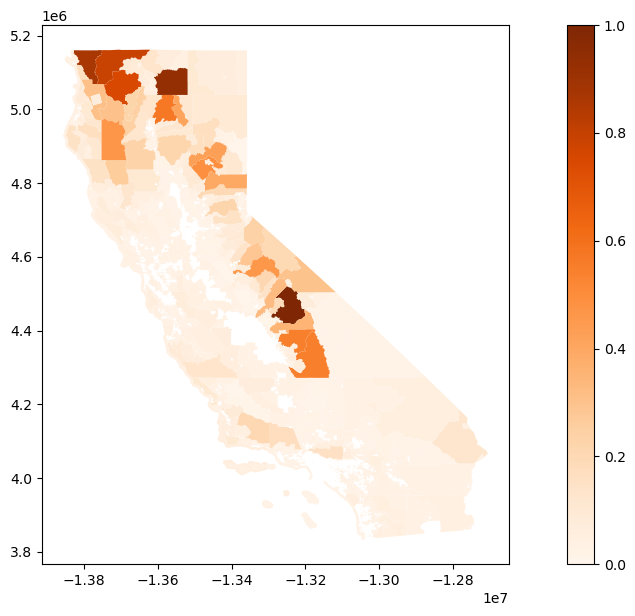

In [88]:
data_std = min_max_standardize(filled_gdf, cols_to_run_on=['hectares'])

#one more quick visual
cmap = 'bwr'
fig, ax = plt.subplots(figsize=(15, 7))
data_std.plot(column='hectares_min_max_standardized', cmap="Oranges", legend=True, ax=ax)

# drop geometry column
data_std = data_std.drop(columns = ['geometry'])

#### Step 5: Export data as csv

In [89]:
data_std.to_csv('climate_wildfire_burned_area_metric.csv')

#### Step 6: Metadata

In [90]:
@append_metadata
def wildfire_burned_area_metadata(df, export=False, export_filename=None, varname=''):
    '''
    Transforms the raw data into the following baseline metrics:
    * Change in total area burned per tract per year
    
    Methods
    -------
    Data is natively modeled area burned
    Uses CMIP5 warming level targets identified from: 
    https://github.com/mathause/cmip_warming_levels/blob/main/warming_levels/cmip5_all_ens/csv/cmip5_warming_levels_all_ens_1850_1900_no_bounds_check.csv
    
    Parameters
    ----------
    df: pd.DataFrame
        Input data.
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI wildfire burn area metric to AWS
        True = will upload resulting df containing CAL CRAI wildfire burn area metric to AWS
    export_filename: string
        name of csv file to be uploaded to AWS
    varname: string
        Final metric name, for metadata generation
        
    Script
    ------
    climate_area_burned.ipynb
    '''
    print('Data transformation: monthly # of hectares summed to annual counts per model.')
          
    # historical baseline
    print("Data transformation: historical baseline data subsetted for 1981-2010, averaging across models.")
    
    # calculate with 2°C WL
    print('Data transformation: data subsetted for warming level of 2.0°C, by manually subsetting based on GWL for parent GCM, and calculating 30 year average, averaging across models.')

    # calculate delta signal
    print("Data transformation: delta signal calculated by taking difference between chronic (2.0°C) and historical baseline.")

    # reprojection to census tracts
    print("Data transformation: data transformed from xarray dataset into pandas dataframe.")
    print("Data transformation: data reprojected from Lambert Conformal Conic CRS to CRS 3857.")
    print("Data transformation: data spatially joined with census tracts.")
    print("Data transformation: point based burn area summed within tracts with valid data (ie, all grid points contain measurements rather than nans)")
    print("Data transformation: tracts which originally contained any nan grid points are masked out with nan values.")
    print("Data transformation: valid data merged with masked data to create a complete geodataframe with all tracts.")
        
    # min-max standardization
    print("Data transformation: data min-max standardized with min_max_standardize function.")
    
    # export data as csv
    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [export_filename]
        upload_csv_aws(export_filename, bucket_name, directory)
        
        # # Check if file exists before attempting to remove it
        # if os.path.exists('climate_wildfire_burned_area_metric.csv'):
        #     os.remove('climate_wildfire_burned_area_metric') # remove from local to clear up directory
        
        # if os.path.exists(export_filename[0]):
        #     os.remove(export_filename[0])
    
    if export == False:
        print(f'{export_filename} uploaded to AWS.')

In [91]:
wildfire_burned_area_metadata(data_std, export=False, export_filename ='climate_wildfire_burned_area_metric.csv', varname='test') # varname)